In [1]:
import sys
import os
project_path = '../../..'
sys.path.append(os.path.abspath(project_path))

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Load Synthetic Data

In [3]:
num_states = 3
D = 1
emission_dist = 't'
save_path = '2020_3states'
folder_path = f"{project_path}/data/synthetic/{emission_dist}-hmm/{save_path}"
s_filename = f"{folder_path}/S_data.npy"
x_filename = f"{folder_path}/X_data.npy"
S = np.load(s_filename)
X = np.load(x_filename)

In [4]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 390
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, train_ratio=0.6, val_ratio=0.2, batch_size=batch_size, standardize=True, feature_engineer=True
)

In [5]:
class ModelParams:
    name = 'mixture_vae'
    
    # backbone parameters
    tau = 0.1
    hard = False
    transition = 'jump'
    lamda_m = 1.0
    lamda_i = 1.0
    lamda_t = 1.0
    seq_len = window_size
    feature = D * 15
    n_cluster = num_states
    hidden_dim = 16
    loss_clamp = batch_size * window_size * 10
    loss_mode = 'sum'
    
    # s_x
    s_x_type = 'lstm'
    s_clamp = 5
    s_x_dropout = 0.1
    s_x_lstm_hidden = 64
    s_x_lstm_layers = 1
    
    # z_s (p)
    
    # z_sx (q)
    z_sx_type = 'mlp'
    z_sx_dropout = 0.1
    z_sx_hiddens = [128, 128]
    
    ######################################
    reconstruction_on_s = True # if True use x_sz else x_z
    
    # x_sz
    x_sz_type = 'mlp'
    reconstruction_on_z = 'p'
    x_sz_dropout = 0.1
    x_sz_hiddens = [128, 128]
    
    # x_z
    x_z_type = 'mlp'
    reconstruction_on_z = 'p'
    x_z_dropout = 0.1
    x_z_hiddens = [128, 128]

model_params = ModelParams

In [6]:
import optuna
import numpy as np
import json
from model.vae_module import VAEModule
from utils.metrics import balanced_accuracy
import os

# Construct the grid for lamda
grid_values = [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 12.0, 15.0, 20.0, 30.0, 40.0, 60.0, 80.0, 100.0]

def objective(trial):
    # Select a lamda value from the predefined grid
    lamda = trial.suggest_categorical("lamda", grid_values)
    
    # Assign the lamda value to the model parameters
    model_params.lamda_m = lamda
    model_params.lamda_i = lamda
    model_params.lamda_t = lamda
    
    vae_module = VAEModule(model_params)
    vae_module.fit(train_loader, lr=1e-3, epochs=300)
    
    # Evaluate model performance on the validation set
    true_s_val, pred_s_val = vae_module.inference(val_loader)
    val_bal_acc = balanced_accuracy(true_s_val.ravel(), pred_s_val.ravel(), n_classes=num_states)
    
    return val_bal_acc

# Define the search space
search_space = {"lamda": grid_values}
sampler = optuna.samplers.GridSampler(search_space)

# Create an Optuna Study with the objective of maximizing Balanced Accuracy
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

# Output the best hyperparameters
print("Best trial:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a file
best_params = best_trial.params

os.makedirs(f"{project_path}/hyper_parameter/best_vae", exist_ok=True)
param_file_name = f"{project_path}/hyper_parameter/best_vae/{save_path}.json"
with open(param_file_name, "w") as f:
    json.dump(best_params, f, indent=4)

print("Best hyperparameters saved to 'best_hyperparameters.json'.")


[I 2025-03-24 14:26:18,957] A new study created in memory with name: no-name-a70d994a-d3de-40e6-a72d-bf5169ffeb61


Epoch [20/300], VAE Loss: 6165.2276
Epoch [40/300], VAE Loss: 5974.8304
Epoch [60/300], VAE Loss: 5944.1305
Epoch [80/300], VAE Loss: 5934.8373
Epoch [100/300], VAE Loss: 5928.5460
Epoch [120/300], VAE Loss: 5917.0429
Epoch [140/300], VAE Loss: 5918.7425
Epoch [160/300], VAE Loss: 5906.0906
Epoch [180/300], VAE Loss: 5899.6819
Epoch [200/300], VAE Loss: 5897.1405
Epoch [220/300], VAE Loss: 5894.2799
Epoch [240/300], VAE Loss: 5895.1147
Epoch [260/300], VAE Loss: 5891.2972
Epoch [280/300], VAE Loss: 5889.9575


[I 2025-03-24 14:26:48,766] Trial 0 finished with value: 0.5806996506566203 and parameters: {'lamda': 2.0}. Best is trial 0 with value: 0.5806996506566203.


Epoch [300/300], VAE Loss: 5889.6415
Epoch [20/300], VAE Loss: 12890.6820
Epoch [40/300], VAE Loss: 12689.2206
Epoch [60/300], VAE Loss: 12615.7081
Epoch [80/300], VAE Loss: 12416.3241
Epoch [100/300], VAE Loss: 12359.5319
Epoch [120/300], VAE Loss: 12345.3703
Epoch [140/300], VAE Loss: 12330.0135
Epoch [160/300], VAE Loss: 12324.6838
Epoch [180/300], VAE Loss: 12306.2947
Epoch [200/300], VAE Loss: 12323.7839
Epoch [220/300], VAE Loss: 12293.1469
Epoch [240/300], VAE Loss: 12286.1140
Epoch [260/300], VAE Loss: 12278.1511
Epoch [280/300], VAE Loss: 12272.6240


[I 2025-03-24 14:27:14,800] Trial 1 finished with value: 0.6210464721358152 and parameters: {'lamda': 9.0}. Best is trial 1 with value: 0.6210464721358152.


Epoch [300/300], VAE Loss: 12266.5682
Epoch [20/300], VAE Loss: 18096.3019
Epoch [40/300], VAE Loss: 17808.2774
Epoch [60/300], VAE Loss: 17661.7290
Epoch [80/300], VAE Loss: 17586.1344
Epoch [100/300], VAE Loss: 17549.4314
Epoch [120/300], VAE Loss: 17517.7077
Epoch [140/300], VAE Loss: 17488.1056
Epoch [160/300], VAE Loss: 17474.3470
Epoch [180/300], VAE Loss: 17467.1444
Epoch [200/300], VAE Loss: 17444.0666
Epoch [220/300], VAE Loss: 17429.5082
Epoch [240/300], VAE Loss: 17417.0135
Epoch [260/300], VAE Loss: 17419.4216
Epoch [280/300], VAE Loss: 17410.7751


[I 2025-03-24 14:27:39,081] Trial 2 finished with value: 0.6348394188523551 and parameters: {'lamda': 15.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 17404.1887
Epoch [20/300], VAE Loss: 22467.1626
Epoch [40/300], VAE Loss: 22014.1209
Epoch [60/300], VAE Loss: 21872.2341
Epoch [80/300], VAE Loss: 21801.3987
Epoch [100/300], VAE Loss: 21736.1908
Epoch [120/300], VAE Loss: 21708.1536
Epoch [140/300], VAE Loss: 21670.6050
Epoch [160/300], VAE Loss: 21643.0854
Epoch [180/300], VAE Loss: 21622.8893
Epoch [200/300], VAE Loss: 21624.1932
Epoch [220/300], VAE Loss: 21618.4755
Epoch [240/300], VAE Loss: 21590.6712
Epoch [260/300], VAE Loss: 21596.3419
Epoch [280/300], VAE Loss: 21583.5915


[I 2025-03-24 14:28:04,327] Trial 3 finished with value: 0.5718097501077675 and parameters: {'lamda': 20.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 21586.7386
Epoch [20/300], VAE Loss: 87992.0752
Epoch [40/300], VAE Loss: 86542.8137
Epoch [60/300], VAE Loss: 86011.3186
Epoch [80/300], VAE Loss: 85710.1650
Epoch [100/300], VAE Loss: 85506.1993
Epoch [120/300], VAE Loss: 85360.2647
Epoch [140/300], VAE Loss: 85260.1307
Epoch [160/300], VAE Loss: 85190.5997
Epoch [180/300], VAE Loss: 85135.3039
Epoch [200/300], VAE Loss: 85094.8905
Epoch [220/300], VAE Loss: 85063.5686
Epoch [240/300], VAE Loss: 85035.8252
Epoch [260/300], VAE Loss: 85007.6029
Epoch [280/300], VAE Loss: 84987.0703


[I 2025-03-24 14:28:30,581] Trial 4 finished with value: 0.3688849772118907 and parameters: {'lamda': 100.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 84968.2157
Epoch [20/300], VAE Loss: 9461.0546
Epoch [40/300], VAE Loss: 8895.7391
Epoch [60/300], VAE Loss: 8836.4072
Epoch [80/300], VAE Loss: 8805.8363
Epoch [100/300], VAE Loss: 8777.2317
Epoch [120/300], VAE Loss: 8762.7851
Epoch [140/300], VAE Loss: 8751.6084
Epoch [160/300], VAE Loss: 8734.6282
Epoch [180/300], VAE Loss: 8736.1338
Epoch [200/300], VAE Loss: 8714.9757
Epoch [220/300], VAE Loss: 8719.5429
Epoch [240/300], VAE Loss: 8714.5491
Epoch [260/300], VAE Loss: 8706.3343
Epoch [280/300], VAE Loss: 8697.5334


[I 2025-03-24 14:28:57,028] Trial 5 finished with value: 0.5932753560188292 and parameters: {'lamda': 5.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 8689.3260
Epoch [20/300], VAE Loss: 7106.5300
Epoch [40/300], VAE Loss: 6938.4994
Epoch [60/300], VAE Loss: 6910.4094
Epoch [80/300], VAE Loss: 6891.0232
Epoch [100/300], VAE Loss: 6879.2441
Epoch [120/300], VAE Loss: 6875.2549
Epoch [140/300], VAE Loss: 6866.3707
Epoch [160/300], VAE Loss: 6863.6598
Epoch [180/300], VAE Loss: 6858.7670
Epoch [200/300], VAE Loss: 6845.9015
Epoch [220/300], VAE Loss: 6840.1532
Epoch [240/300], VAE Loss: 6838.7230
Epoch [260/300], VAE Loss: 6842.3074
Epoch [280/300], VAE Loss: 6837.2916


[I 2025-03-24 14:29:23,631] Trial 6 finished with value: 0.5905640213292629 and parameters: {'lamda': 3.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 6830.6699
Epoch [20/300], VAE Loss: 72952.2712
Epoch [40/300], VAE Loss: 70639.2353
Epoch [60/300], VAE Loss: 70140.8309
Epoch [80/300], VAE Loss: 69860.8170
Epoch [100/300], VAE Loss: 69667.1225
Epoch [120/300], VAE Loss: 69522.8750
Epoch [140/300], VAE Loss: 69434.2296
Epoch [160/300], VAE Loss: 69371.4592
Epoch [180/300], VAE Loss: 69326.9910
Epoch [200/300], VAE Loss: 69289.1675
Epoch [220/300], VAE Loss: 69261.4428
Epoch [240/300], VAE Loss: 69237.4747
Epoch [260/300], VAE Loss: 69214.4812
Epoch [280/300], VAE Loss: 69192.6650


[I 2025-03-24 14:29:48,600] Trial 7 finished with value: 0.402474944782125 and parameters: {'lamda': 80.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 69178.0752
Epoch [20/300], VAE Loss: 31036.5948
Epoch [40/300], VAE Loss: 30192.0866
Epoch [60/300], VAE Loss: 30002.1989
Epoch [80/300], VAE Loss: 29893.3423
Epoch [100/300], VAE Loss: 29821.0617
Epoch [120/300], VAE Loss: 29769.1573
Epoch [140/300], VAE Loss: 29728.0241
Epoch [160/300], VAE Loss: 29700.6230
Epoch [180/300], VAE Loss: 29680.5694
Epoch [200/300], VAE Loss: 29665.6454
Epoch [220/300], VAE Loss: 29651.6752
Epoch [240/300], VAE Loss: 29639.8374
Epoch [260/300], VAE Loss: 29631.9865
Epoch [280/300], VAE Loss: 29622.8542


[I 2025-03-24 14:30:15,368] Trial 8 finished with value: 0.5249756242508526 and parameters: {'lamda': 30.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 29615.8599
Epoch [20/300], VAE Loss: 15695.0304
Epoch [40/300], VAE Loss: 15341.9406
Epoch [60/300], VAE Loss: 15201.1522
Epoch [80/300], VAE Loss: 15076.8180
Epoch [100/300], VAE Loss: 15010.3550
Epoch [120/300], VAE Loss: 14978.0092
Epoch [140/300], VAE Loss: 14963.5353
Epoch [160/300], VAE Loss: 14955.9502
Epoch [180/300], VAE Loss: 14926.8433
Epoch [200/300], VAE Loss: 14903.5088
Epoch [220/300], VAE Loss: 14916.7667
Epoch [240/300], VAE Loss: 14898.8640
Epoch [260/300], VAE Loss: 14889.8180
Epoch [280/300], VAE Loss: 14894.6197


[I 2025-03-24 14:30:41,583] Trial 9 finished with value: 0.6269017233253464 and parameters: {'lamda': 12.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 14881.3554
Epoch [20/300], VAE Loss: 39925.4183
Epoch [40/300], VAE Loss: 38278.4935
Epoch [60/300], VAE Loss: 38019.9526
Epoch [80/300], VAE Loss: 37875.8440
Epoch [100/300], VAE Loss: 37781.8554
Epoch [120/300], VAE Loss: 37705.7516
Epoch [140/300], VAE Loss: 37655.3407
Epoch [160/300], VAE Loss: 37618.6238
Epoch [180/300], VAE Loss: 37590.5417
Epoch [200/300], VAE Loss: 37569.4212
Epoch [220/300], VAE Loss: 37553.3971
Epoch [240/300], VAE Loss: 37539.8538
Epoch [260/300], VAE Loss: 37527.9530
Epoch [280/300], VAE Loss: 37515.4649


[I 2025-03-24 14:31:07,924] Trial 10 finished with value: 0.34936119591117953 and parameters: {'lamda': 40.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 37506.4747
Epoch [20/300], VAE Loss: 8354.0857
Epoch [40/300], VAE Loss: 7924.1854
Epoch [60/300], VAE Loss: 7869.7325
Epoch [80/300], VAE Loss: 7848.8241
Epoch [100/300], VAE Loss: 7834.0574
Epoch [120/300], VAE Loss: 7824.0401
Epoch [140/300], VAE Loss: 7814.1920
Epoch [160/300], VAE Loss: 7799.7422
Epoch [180/300], VAE Loss: 7796.3813
Epoch [200/300], VAE Loss: 7786.7351
Epoch [220/300], VAE Loss: 7783.0291
Epoch [240/300], VAE Loss: 7777.7466
Epoch [260/300], VAE Loss: 7776.8445
Epoch [280/300], VAE Loss: 7770.7341


[I 2025-03-24 14:31:34,641] Trial 11 finished with value: 0.5838047959777038 and parameters: {'lamda': 4.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 7769.3123
Epoch [20/300], VAE Loss: 5193.4653
Epoch [40/300], VAE Loss: 4996.1187
Epoch [60/300], VAE Loss: 4973.3922
Epoch [80/300], VAE Loss: 4959.1071
Epoch [100/300], VAE Loss: 4952.7407
Epoch [120/300], VAE Loss: 4947.2942
Epoch [140/300], VAE Loss: 4945.1014
Epoch [160/300], VAE Loss: 4936.5089
Epoch [180/300], VAE Loss: 4937.5197
Epoch [200/300], VAE Loss: 4934.5807
Epoch [220/300], VAE Loss: 4933.2784
Epoch [240/300], VAE Loss: 4930.7742
Epoch [260/300], VAE Loss: 4926.7519
Epoch [280/300], VAE Loss: 4927.0449


[I 2025-03-24 14:31:59,399] Trial 12 finished with value: 0.5778456762213576 and parameters: {'lamda': 1.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 4922.4531
Epoch [20/300], VAE Loss: 11134.5406
Epoch [40/300], VAE Loss: 10720.0376
Epoch [60/300], VAE Loss: 10643.5535
Epoch [80/300], VAE Loss: 10604.7720
Epoch [100/300], VAE Loss: 10588.6246
Epoch [120/300], VAE Loss: 10565.8695
Epoch [140/300], VAE Loss: 10563.6548
Epoch [160/300], VAE Loss: 10557.7925
Epoch [180/300], VAE Loss: 10541.5414
Epoch [200/300], VAE Loss: 10530.9189
Epoch [220/300], VAE Loss: 10529.3339
Epoch [240/300], VAE Loss: 10519.1599
Epoch [260/300], VAE Loss: 10513.8689
Epoch [280/300], VAE Loss: 10501.3673


[I 2025-03-24 14:32:24,288] Trial 13 finished with value: 0.605180708687589 and parameters: {'lamda': 7.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 10502.6632
Epoch [20/300], VAE Loss: 55471.0392
Epoch [40/300], VAE Loss: 54330.8979
Epoch [60/300], VAE Loss: 53990.9730
Epoch [80/300], VAE Loss: 53804.7410
Epoch [100/300], VAE Loss: 53666.6691
Epoch [120/300], VAE Loss: 53570.9346
Epoch [140/300], VAE Loss: 53508.2475
Epoch [160/300], VAE Loss: 53468.3072
Epoch [180/300], VAE Loss: 53438.4363
Epoch [200/300], VAE Loss: 53413.5425
Epoch [220/300], VAE Loss: 53393.5433
Epoch [240/300], VAE Loss: 53376.6765
Epoch [260/300], VAE Loss: 53359.2770
Epoch [280/300], VAE Loss: 53345.6185


[I 2025-03-24 14:32:49,237] Trial 14 finished with value: 0.36957632453988154 and parameters: {'lamda': 60.0}. Best is trial 2 with value: 0.6348394188523551.


Epoch [300/300], VAE Loss: 53333.3799
Best trial:
  lamda: 15.0
Best hyperparameters saved to 'best_hyperparameters.json'.


In [14]:
# Load the best hyper-parameter
with open(param_file_name, "r") as f:
    loaded_params = json.load(f)

print("Loaded hyperparameters:")
print(loaded_params)

model_params.lamda_m = loaded_params['lamda']
model_params.lamda_i = loaded_params['lamda']
model_params.lamda_t = loaded_params['lamda']

vae_module = VAEModule(model_params)
vae_module.fit(train_loader, lr=1e-3, epochs=300)

Loaded hyperparameters:
{'lamda': 15.0}
Epoch [20/300], VAE Loss: 18038.1062
Epoch [40/300], VAE Loss: 17703.2087
Epoch [60/300], VAE Loss: 17594.0174
Epoch [80/300], VAE Loss: 17550.3964
Epoch [100/300], VAE Loss: 17502.0333
Epoch [120/300], VAE Loss: 17468.4647
Epoch [140/300], VAE Loss: 17455.1558
Epoch [160/300], VAE Loss: 17446.6242
Epoch [180/300], VAE Loss: 17434.0094
Epoch [200/300], VAE Loss: 17415.7120
Epoch [220/300], VAE Loss: 17409.8562
Epoch [240/300], VAE Loss: 17407.1264
Epoch [260/300], VAE Loss: 17418.5588
Epoch [280/300], VAE Loss: 17397.3489
Epoch [300/300], VAE Loss: 17394.9978


In [15]:
true_s_train_vae, pred_s_train_vae = vae_module.inference(train_loader)
true_s_test_vae, pred_s_test_vae = vae_module.inference(test_loader)

vae_bal_acc_train = balanced_accuracy(true_s_train_vae.ravel(), pred_s_train_vae.ravel(), n_classes = num_states)
vae_bal_acc_test = balanced_accuracy(true_s_test_vae.ravel(), pred_s_test_vae.ravel(), n_classes = num_states)
print(f"[VAE] Balanced Accuracy [train]: {vae_bal_acc_train:.4f}")
print(f"[VAE] Balanced Accuracy [test]: {vae_bal_acc_test:.4f}")

[VAE] Balanced Accuracy [train]: 0.6341
[VAE] Balanced Accuracy [test]: 0.6497


# Visualization

In [24]:
from utils.visualize import plot_clusters
num = 10
all_x_input, all_z_embed = vae_module.get_embedding(test_loader)
original_embed = all_x_input[:num].reshape(-1, all_x_input.shape[-1])
latent_embed = all_z_embed[:num].reshape(-1, all_z_embed.shape[-1])
pred_label = pred_s_test_vae[:num].ravel()
true_label = true_s_test_vae[:num].ravel()

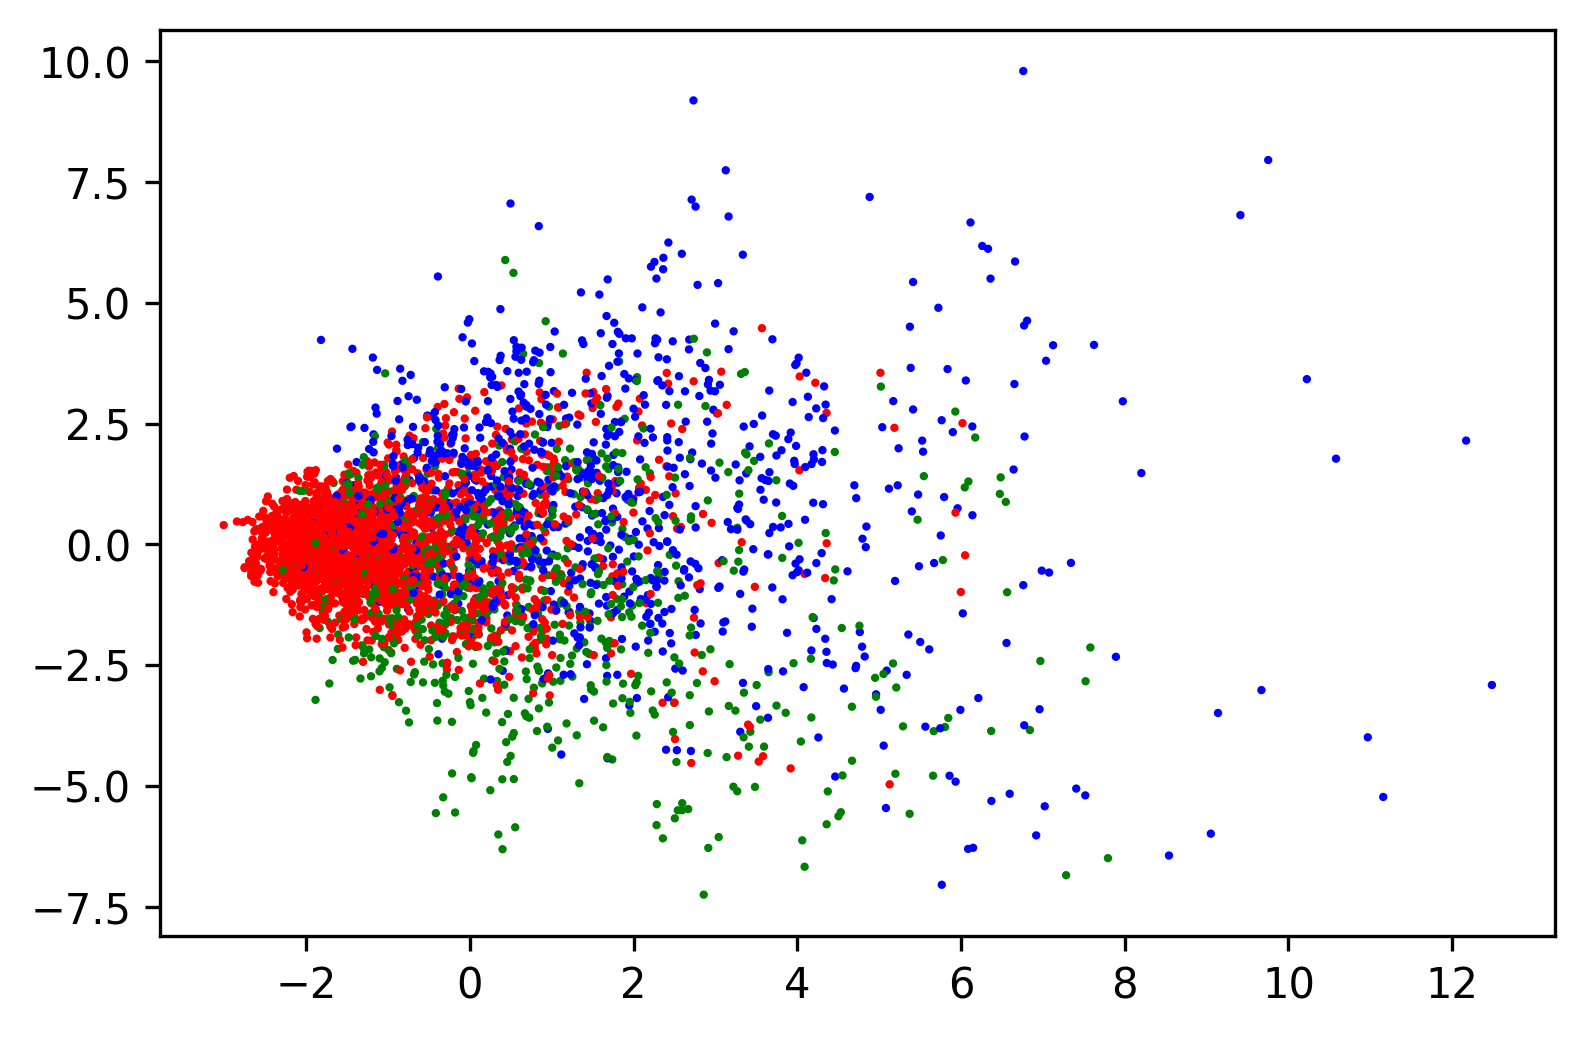

In [31]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['green', 'red', 'blue'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_origin_true.png",
    dpi=300,
    marker_size=1,
    legend=False
)

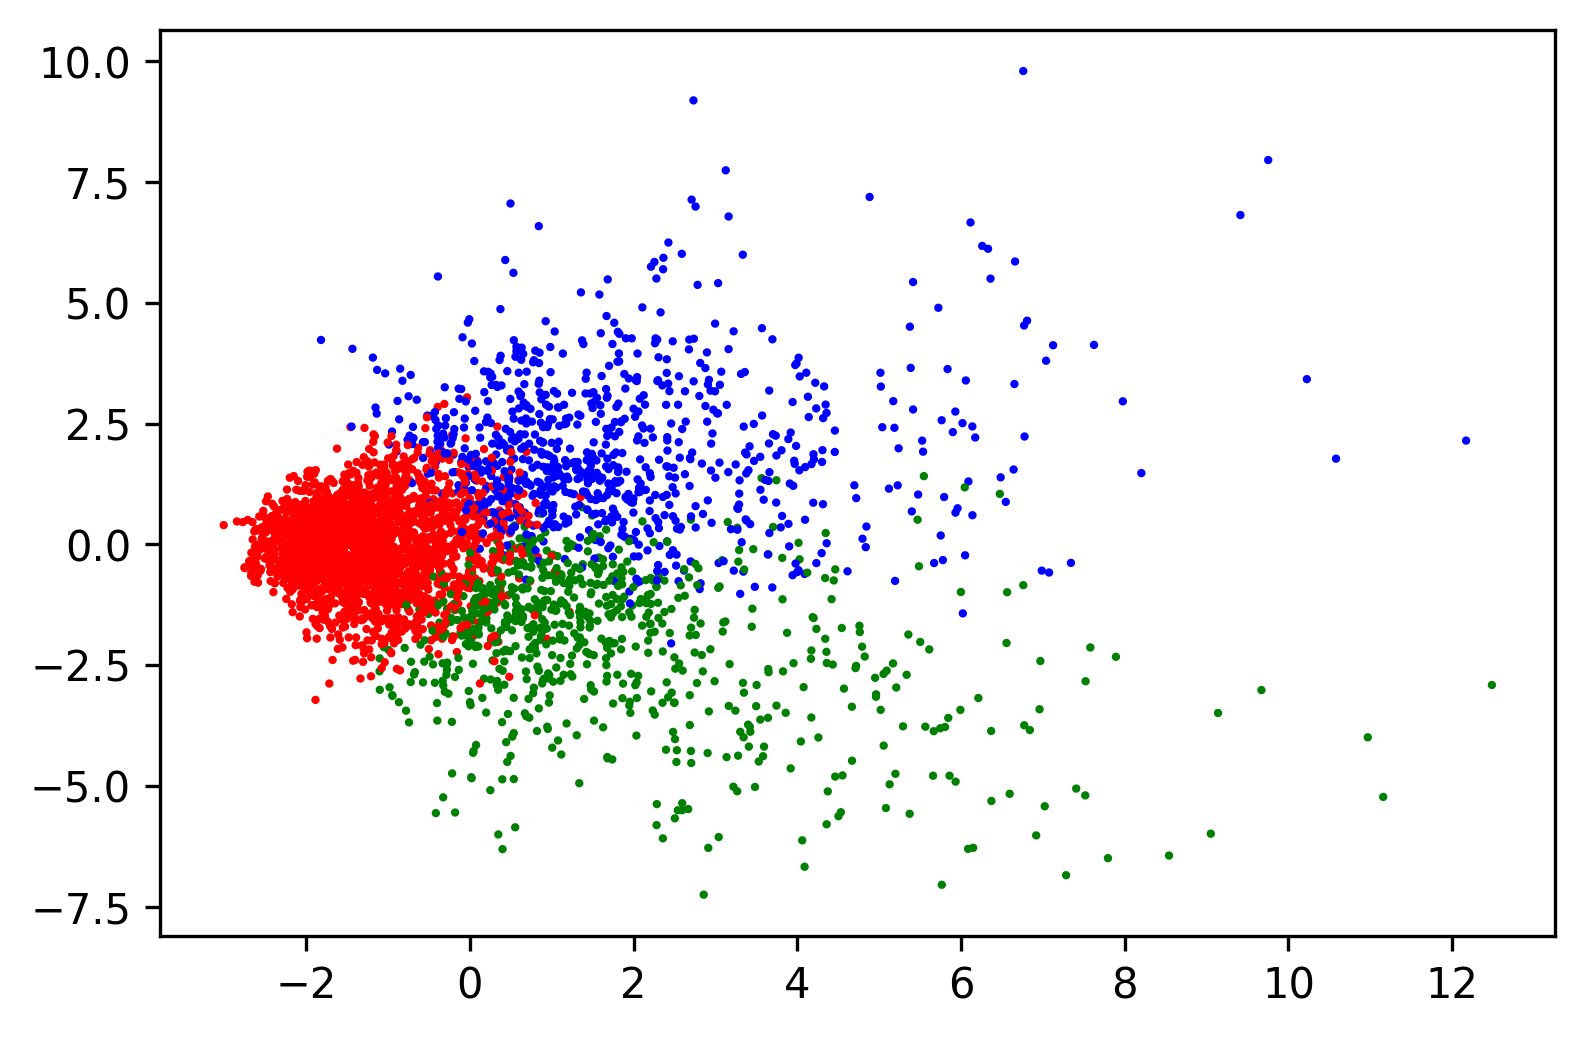

In [32]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_label,
    cluster_count=num_states,
    colors=['blue', 'green', 'red'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_origin_pred.png",
    dpi=300,
    marker_size=1,
    legend=False
)

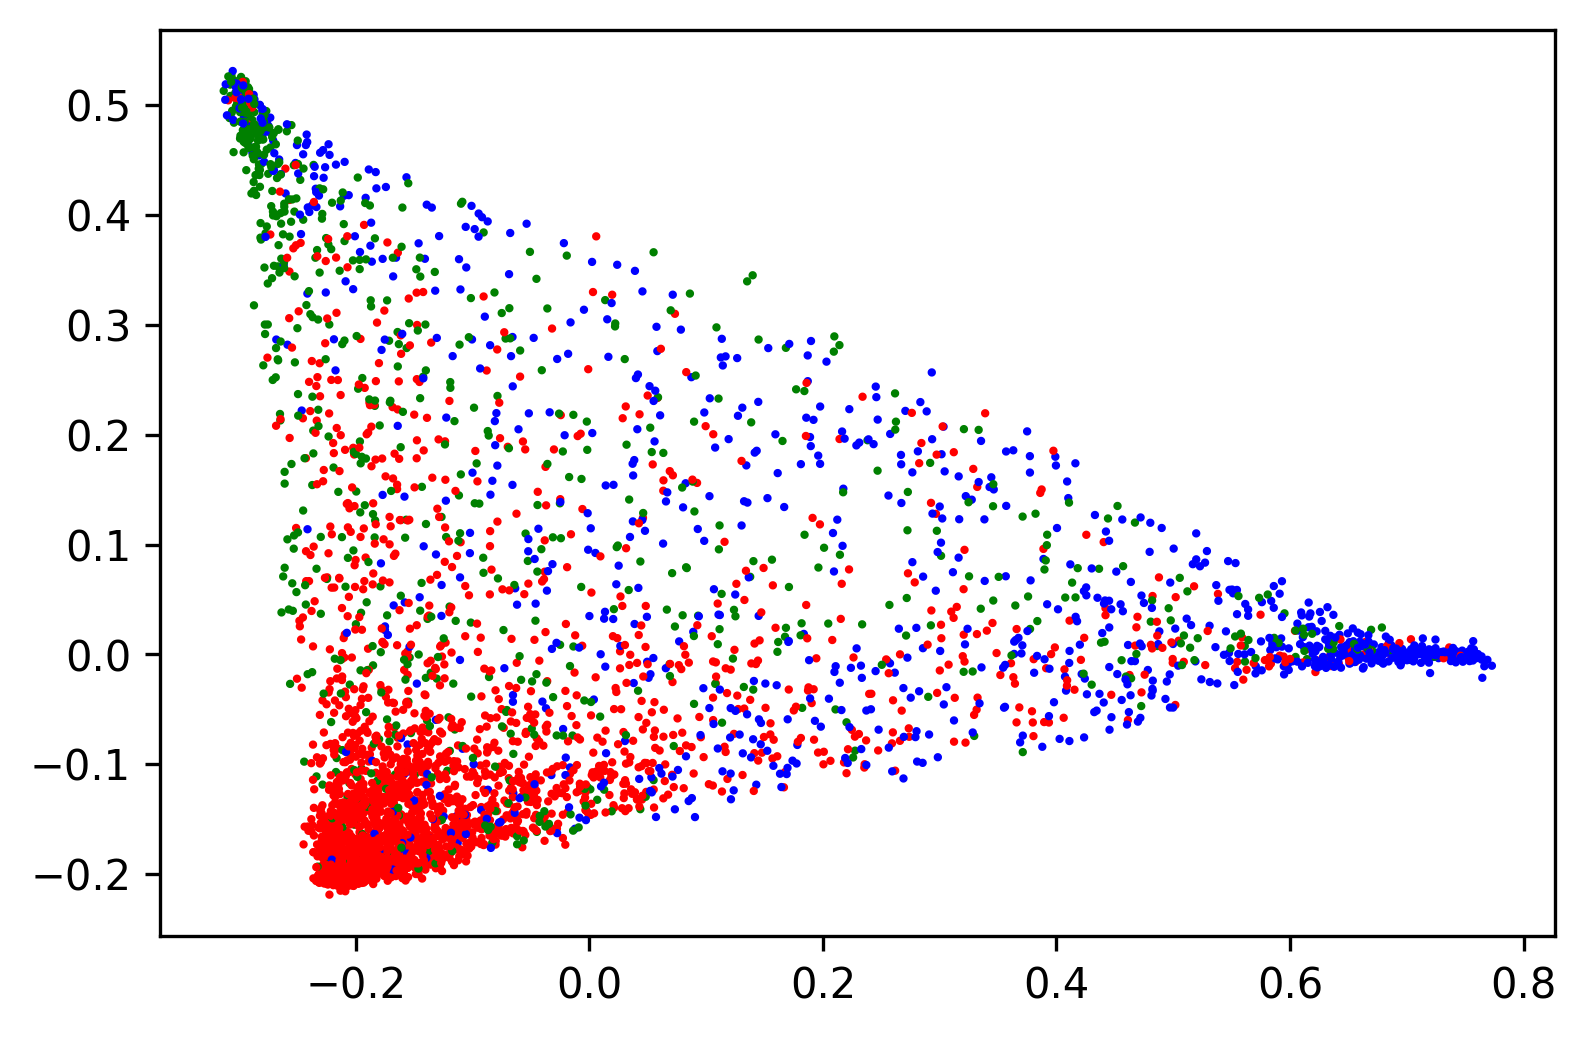

In [34]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['green', 'red', 'blue'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_latent_true.png",
    dpi=300,
    marker_size=1,
    legend=False
)

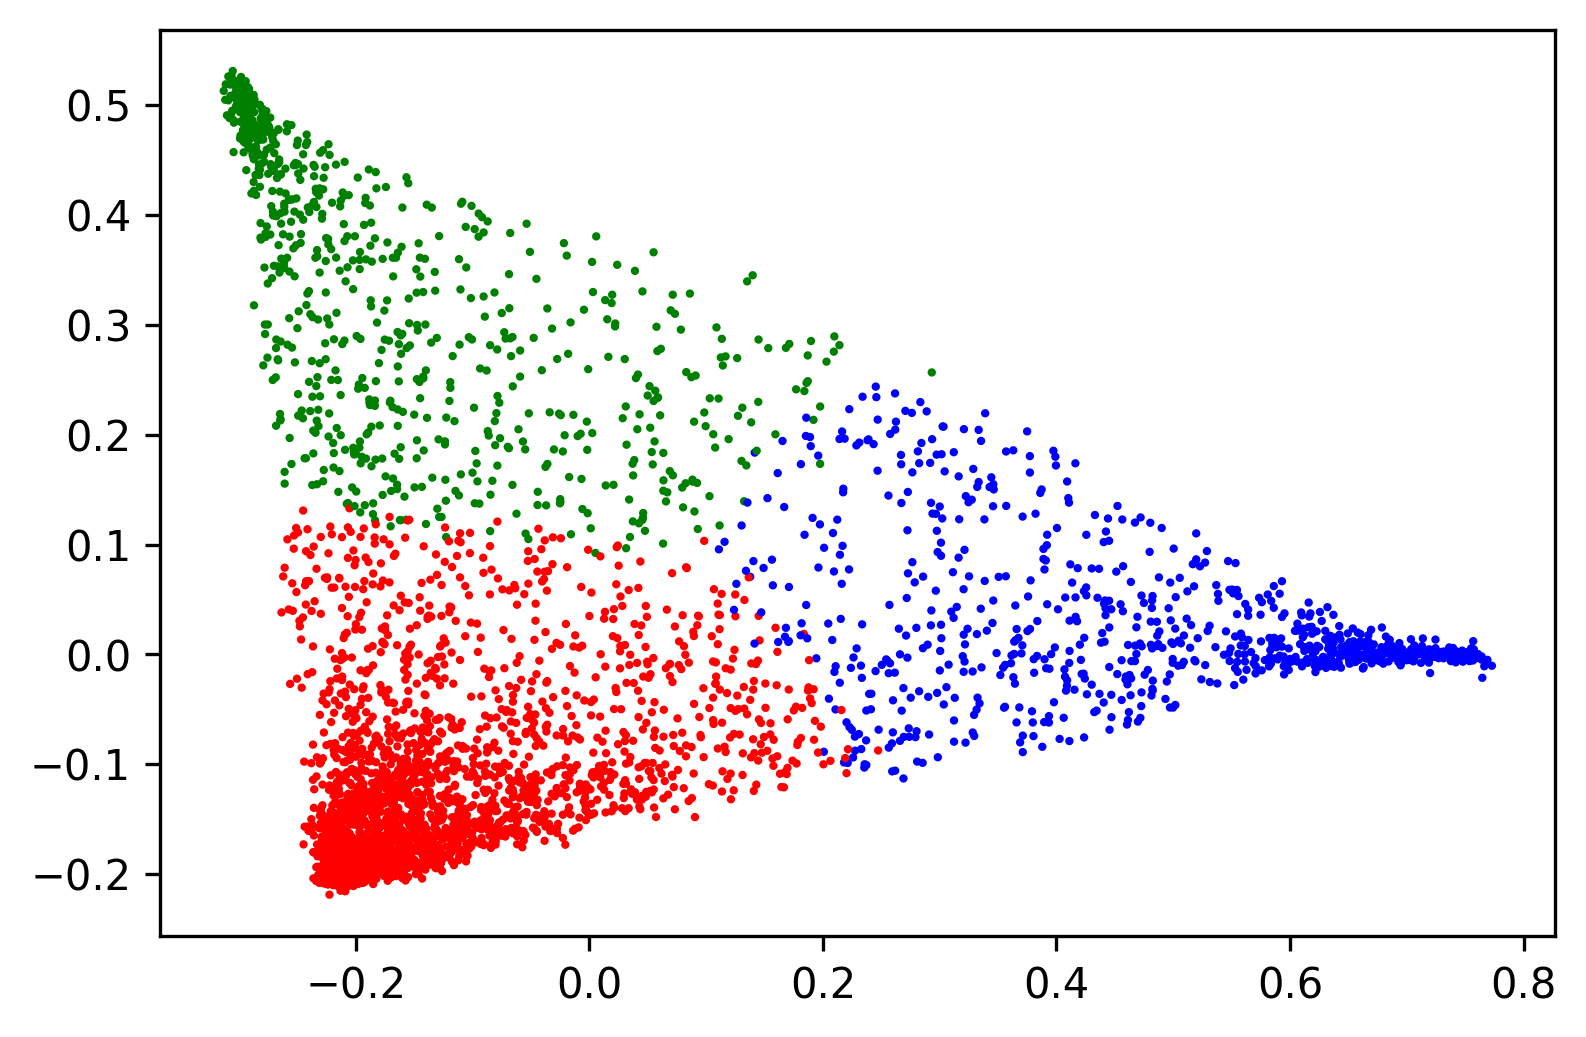

In [33]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=pred_label,
    cluster_count=num_states,
    colors=['blue', 'green', 'red'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=f"{project_path}/figures/{save_path}/VAE_latent_pred.png",
    dpi=300,
    marker_size=1,
    legend=False
)